This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll

# Solving for steady state concentrations using enzyme perturbation data

In [3]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)
# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index) 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [4]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Solving for steady state internal metabolite concentrations (X)

In [5]:
enzymes = [i for i in data.columns if 'e_' in i]

a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]
pt_enz.insert(0, 'e_vPGK')

C:\Users\user\AppData\Local\Temp\ipykernel_18608\4088482062.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [6]:
a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [7]:
# get the real flux values
real_flux_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_flux_values = real_flux_values.div(real_flux_values.iloc[0])
# rel_real_flux_values.drop(rel_real_flux_values.index[0], inplace=True)
rel_real_flux_values.columns = r.getReactionIds()
rel_real_flux_values = rel_real_flux_values.transpose()
rel_real_flux_values.columns = enzPtLvls

In [8]:
# get the real inmet values
real_inmet_values = data[[i for i in data.columns if i in r.getFloatingSpeciesIds()]]
rel_real_inmet_values = real_inmet_values.div(real_inmet_values.iloc[0])
# rel_real_inmet_values.drop(rel_real_inmet_values.index[0], inplace=True)
rel_real_inmet_values = rel_real_inmet_values.transpose()
rel_real_inmet_values.columns = enzPtLvls
rel_real_inmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
P            1.0    0.981102    1.012340    0.999760    1.000185   
G6P          1.0    0.915856    1.062600    1.095768    0.926054   
TRIO         1.0    0.964675    1.024681    0.999533    1.000361   
NAD          1.0    0.999887    1.000075    0.999999    1.000001   
ACE          1.0    0.988426    1.007765    0.999851    1.000115   
P2G          1.0    0.931656    1.050402    0.999068    1.000721   
BPG          1.0    0.884451    1.088375    0.998389    1.001244   
GLCi         1.0    1.275019    0.822960    1.003465    0.997325   
F6P          1.0    0.889588    1.082729    0.998479    1.001177   
PEP          1.0    0.912582    1.065984    0.998792    1.000935   
PYR          1.0    0.945724    1.039756    0.999263    1.000570   
F16P         1.0    0.932066    1.048850    0.999087    1.000706   
P3G          1.0    0.936616    1.046442    0.999139    1.000666   
NADH         1.0    1.003918    0.997385    1.000050    0.999961   

      e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
P         1.016028      0.983496      1.011134      0.988638    0.999814   
G6P       1.060964      0.944343      1.043482      0.959234    1.074261   
TRIO      1.019700      0.981049      1.014680      0.985711    0.999638   
NAD       1.000071      0.999931      1.000052      0.999949    0.999999   
ACE       1.005985      0.994055      1.004513      0.995505    0.999884   
P2G       1.043488      0.959794      1.031735      0.969992    0.999277   
BPG       1.094467      0.915913      1.066104      0.939124    0.998750   
GLCi      0.971681      1.030843      0.980221      1.020988    1.002687   
F6P       1.086807      0.921304      1.061102      0.942995    1.123996   
PEP       1.064690      0.941533      1.046002      0.957185    0.999063   
PYR       1.026599      0.974265      1.020568      0.980019    0.999428   
F16P      1.037958      0.964015      1.028371      0.972702    0.999292   
P3G       1.039000      0.963712      1.028632      0.972806    0.999332   
NADH      0.997514      1.002408      0.998204      1.001762    1.000039   

      e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
P       1.000140    0.999962    1.000030      0.990269      1.008725   
G6P     0.944260    1.015330    0.988048      1.023501      0.983821   
TRIO    1.000272    0.999925    1.000058      1.109371      0.913130   
NAD     1.000001    1.000000    1.000000      1.000711      0.999320   
ACE     1.000087    0.999976    1.000019      1.023951      0.978139   
P2G     1.000543    0.999851    1.000116      0.978715      1.020216   
BPG     1.000938    0.999742    1.000200      0.951653      1.046921   
GLCi    0.997983    1.000555    0.999568      1.019794      0.982896   
F6P     0.906949    1.025595    0.980047      1.041463      0.971095   
PEP     1.000705    0.999806    1.000151      0.967394      1.031373   
PYR     1.000430    0.999882    1.000092      0.987900      1.011103   
F16P    1.000532    1.060552    0.953532      1.187275      0.864676   
P3G     1.000502    0.999862    1.000108      0.981025      1.017955   
NADH    0.999971    1.000008    0.999994      0.975267      1.023632   

      e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
P       0.999709    1.000239    0.999761    1.000194    0.999313    1.000506   
G6P     1.000617    0.999498    1.000505    0.999592    1.001464    0.998939   
TRIO    1.003071    0.997492    1.002517    0.997958    1.007270    0.994686   
NAD     1.000022    0.999982    1.000018    0.999985    1.000052    0.999962   
ACE     1.000723    0.999407    1.000593    0.999517    1.001707    0.998741   
P2G     0.999345    1.000538    0.999462    1.000438    1.141534    0.897163   
BPG     1.037573    0.969339    1.030797    0.975037    1.088997    0.935059   
GLCi    1.000581    0.999524    1.000476    0.999613    1.001373    0.998991   
F6P     1.001094    0.999110    1.000897   

In [9]:
# get the real exmet values
real_exmet_values = data[[i for i in data.columns if i in r.getBoundarySpeciesIds()]]
rel_real_exmet_values = real_exmet_values.div(real_exmet_values.iloc[0])
# rel_real_exmet_values.drop(rel_real_exmet_values.index[0], inplace=True)
rel_real_exmet_values = rel_real_exmet_values.transpose()
rel_real_exmet_values.columns = enzPtLvls
rel_real_exmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0   

       e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
CO2             1.0           1.0           1.0           1.0         1.0   
GLCo            1.0           1.0           1.0           1.0         1.0   
ETOH            1.0           1.0           1.0           1.0         1.0   
GLY             1.0           1.0           1.0           1.0         1.0   
F26BP           1.0           1.0           1.0           1.0         1.0   

       e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
CO2           1.0         1.0         1.0           1.0           1.0   
GLCo          1.0         1.0         1.0           1.0           1.0   
ETOH          1.0         1.0         1.0           1.0           1.0   
GLY           1.0         1.0         1.0           1.0           1.0   
F26BP         1.0         1.0         1.0           1.0           1.0   

       e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vPYK|0.9  e_vPYK|1.1  e_vPDC|0.9  e_vPDC|1.1  e_vSUC|0.9  e_vSUC|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vGLT|0.9  e_vGLT|1.1  e_vADH|0.9  e_vADH|1.1  e_vG3PDH|0.9  \
CO2           1.0         1.0         1.0         1.0           1.0   
GLCo          1.0         1.0         1.0         1.0           1.0   
ETOH          1.0         1.0         1.0         1.0           1.0   
GLY           1.0         1.0         1.0         1.0           1.0   
F26BP         1.0         1.0         1.0         1.0           1.0   

       e_vG3PDH|1.1  e_vATP|0.9  e_vATP|1.1  e_vGLK|0.887  e_vGLK|1.113  \
CO2             1.0         1.0         1.0           1.0           1.0   
GLCo            1.0         1.0         1.0           1.0           1.0   
ETOH            1.0         1.0         1.0           1.0           1.0   
GLY             1.0         1.0         1.0           1.0           1.0   
F26BP           1.0         1.0         1.0           1.0           1.0   

       e_vPGI|0.887  e_vPGI|1.113  e_vGLYCO|0.887  e_vGLYCO|1.113  \
CO2             1.0           1.0             1.0             1.0   
GLCo            1.0           1.0             1.0             1.0   
ETOH            1.0           1.0             1.0             1.0   
GLY             1.0           1.0             1.0             1.0   
F26BP           1.0           1.0             1.0             1.0   

       e_vTreha|0.887  e_vTreha|1.113  e_vPFK|0.887  e_vPFK|1.113  \
CO2               1.0             1.0           1.0           1.0   
GLCo              1.0             1.0           1.0           1.0   
ETOH              1.0             1.0           1.0           1.0   
GLY               1.0             1.0           1.0           1.0   
F26BP             1.0             1.0           1.0           1.0   

       e

Setting up approximation calculation with simulated values

In [10]:
N = BIOMD64.N
Ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))


In [11]:
pt_lvls = list(set([i.split('|')[1] for i in rel_real_flux_values.columns]))
pt_lvls.sort()

In [12]:
enzyme_perts = data[[i for i in data.columns if 'e_' in i]]
enzyme_perts = enzyme_perts.transpose()
enzyme_perts.columns = enzPtLvls
enzyme_perts.shape

(17, 642)

In [13]:
# data for graphing
x_data = data[r.getFloatingSpeciesIds()]
x_star = x_data.iloc[0].values
x_star[x_star == 0] = 1e-6
xn = x_data.divide(x_star)

y_data = data[r.getBoundarySpeciesIds()]
y_star = y_data.iloc[0].values
y_star[y_star == 0] = 1e-6
yn = y_data.divide(y_star)

vn = real_flux_values
e_hat = enzyme_perts.values.T

In [14]:
n_exp = len(data)
e_hat = enzyme_perts.values.T# [:,:]
v_star = BIOMD64.v_star[np.newaxis,:]
product = (e_hat*v_star)

def my_func(a): 
    return np.diag(a)

c = np.apply_along_axis(my_func, 1, product)

N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)

A = (N_rep@c@Ex) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Xss = []
for i in range(n_exp): 
    Xss.append(np.linalg.pinv(A[i])@b[i])


### Graphing the steady state internal concentrations

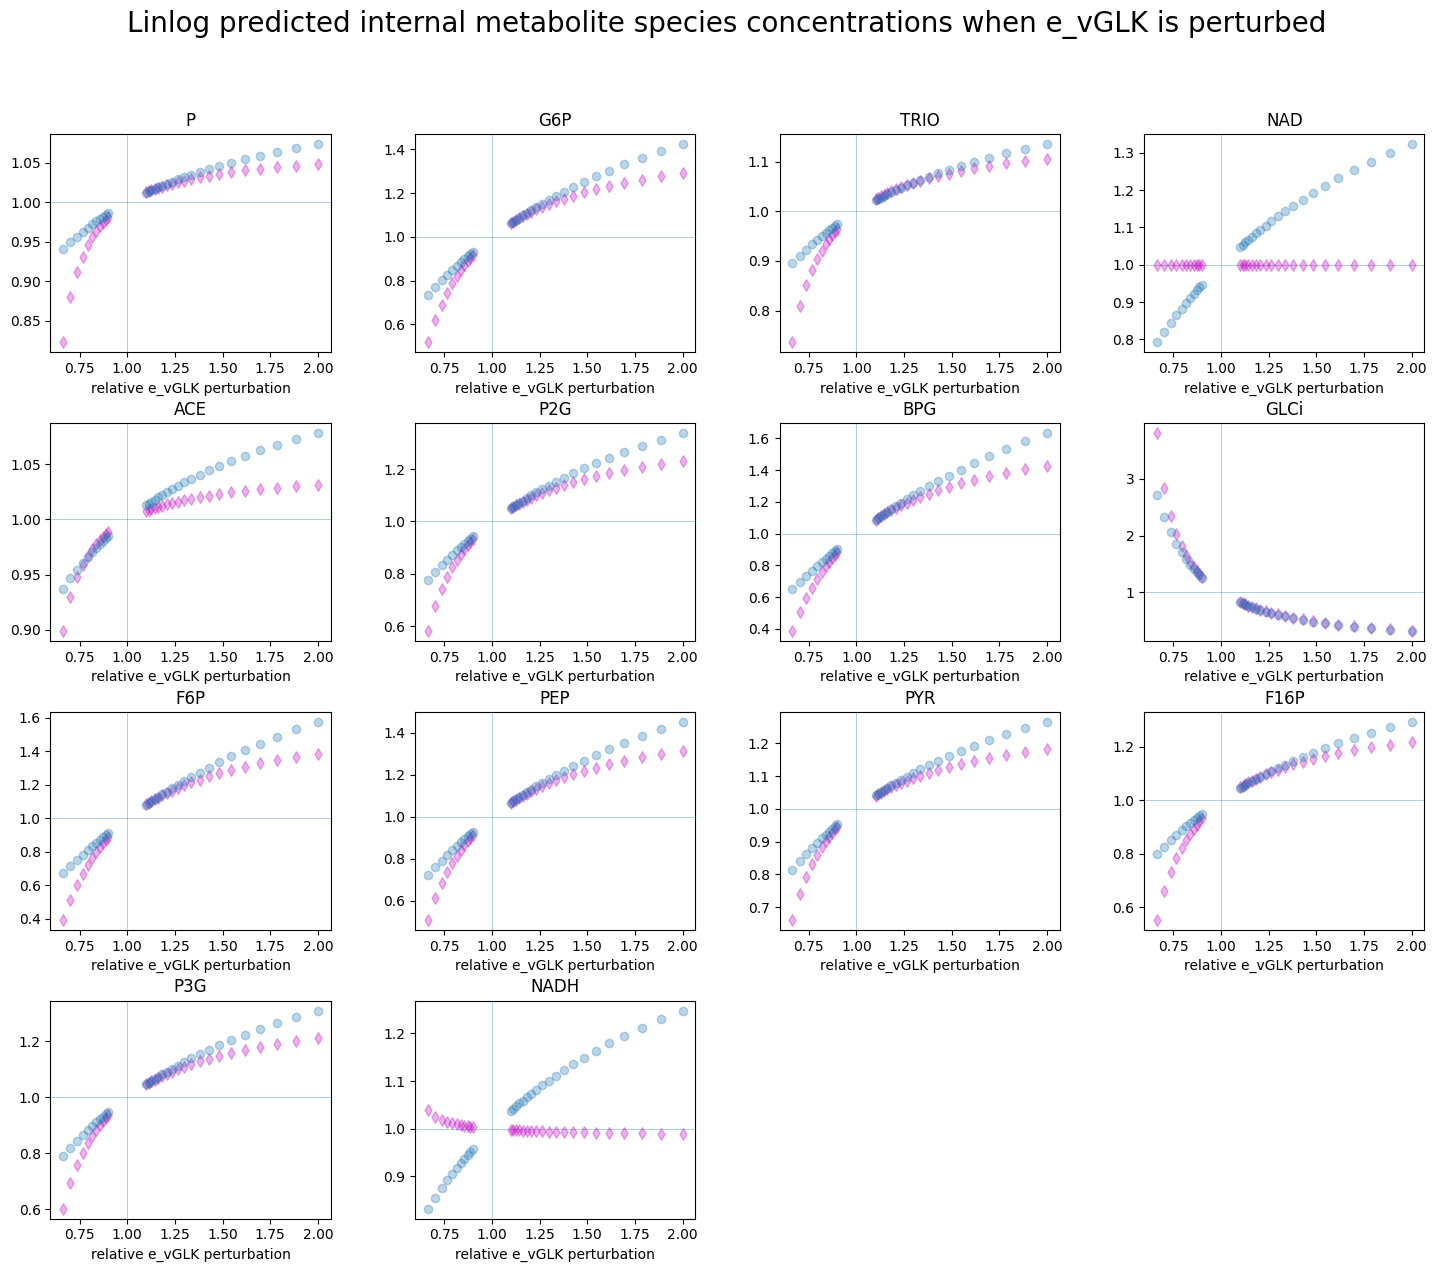

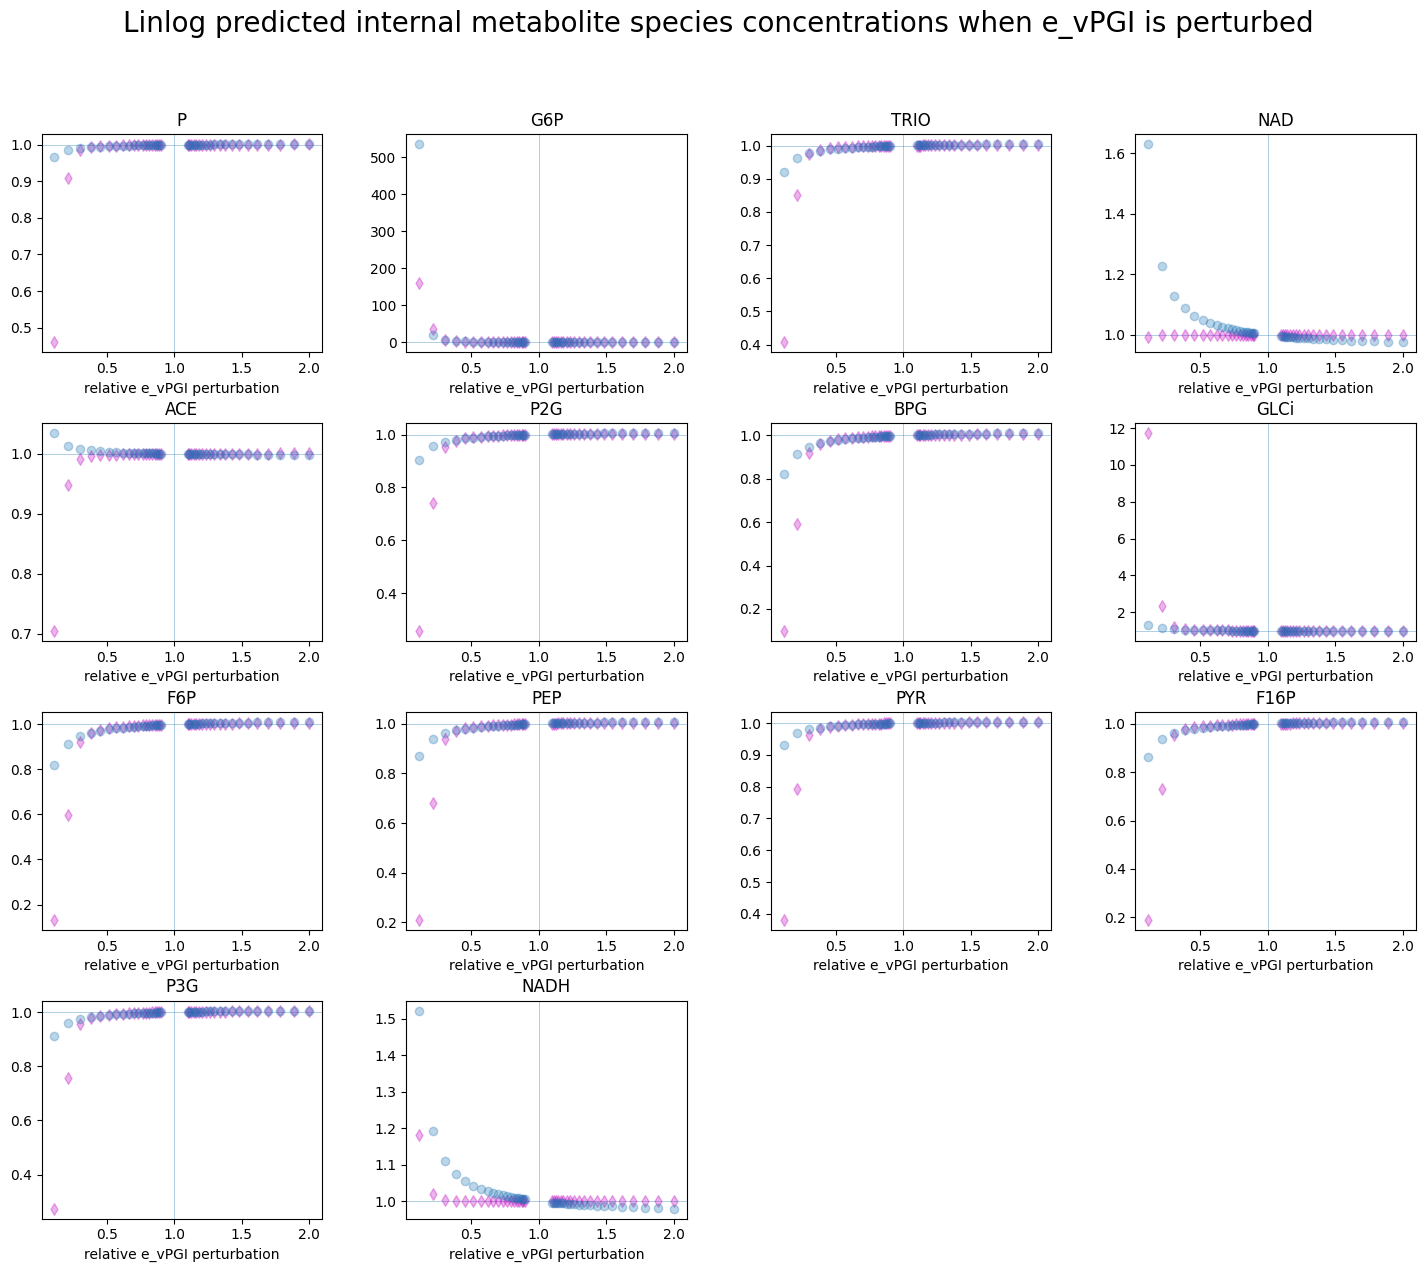

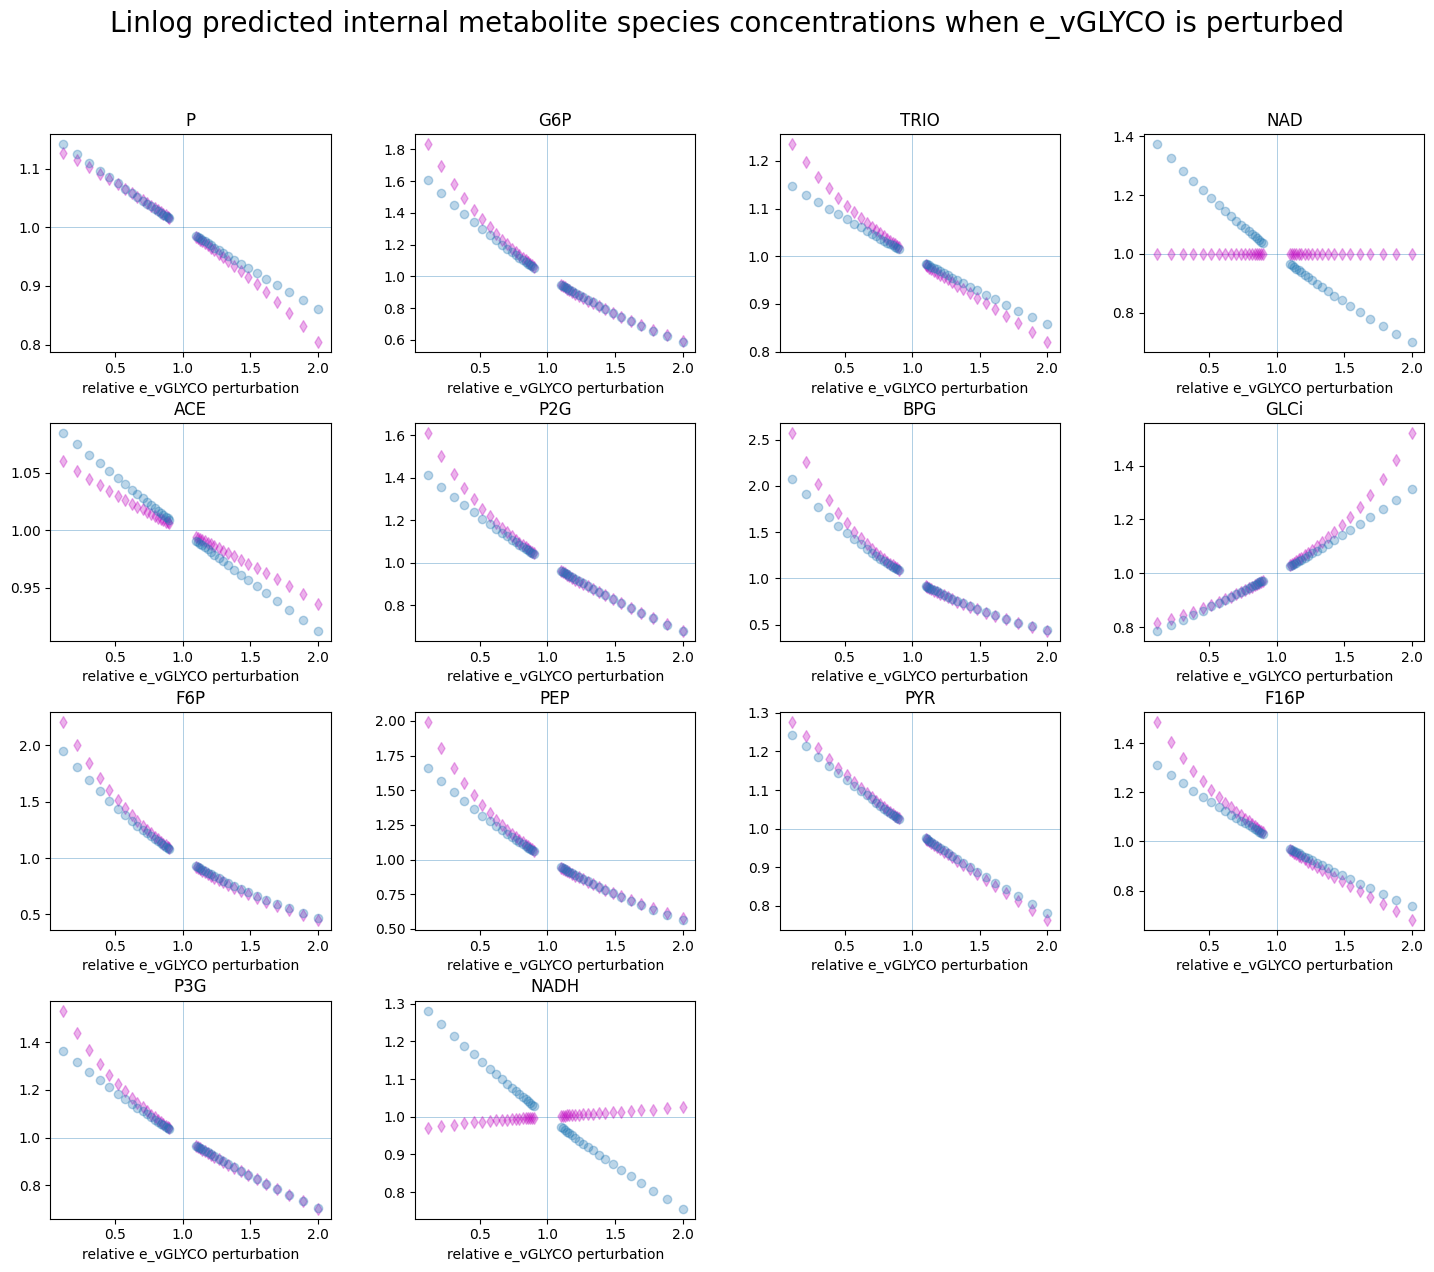

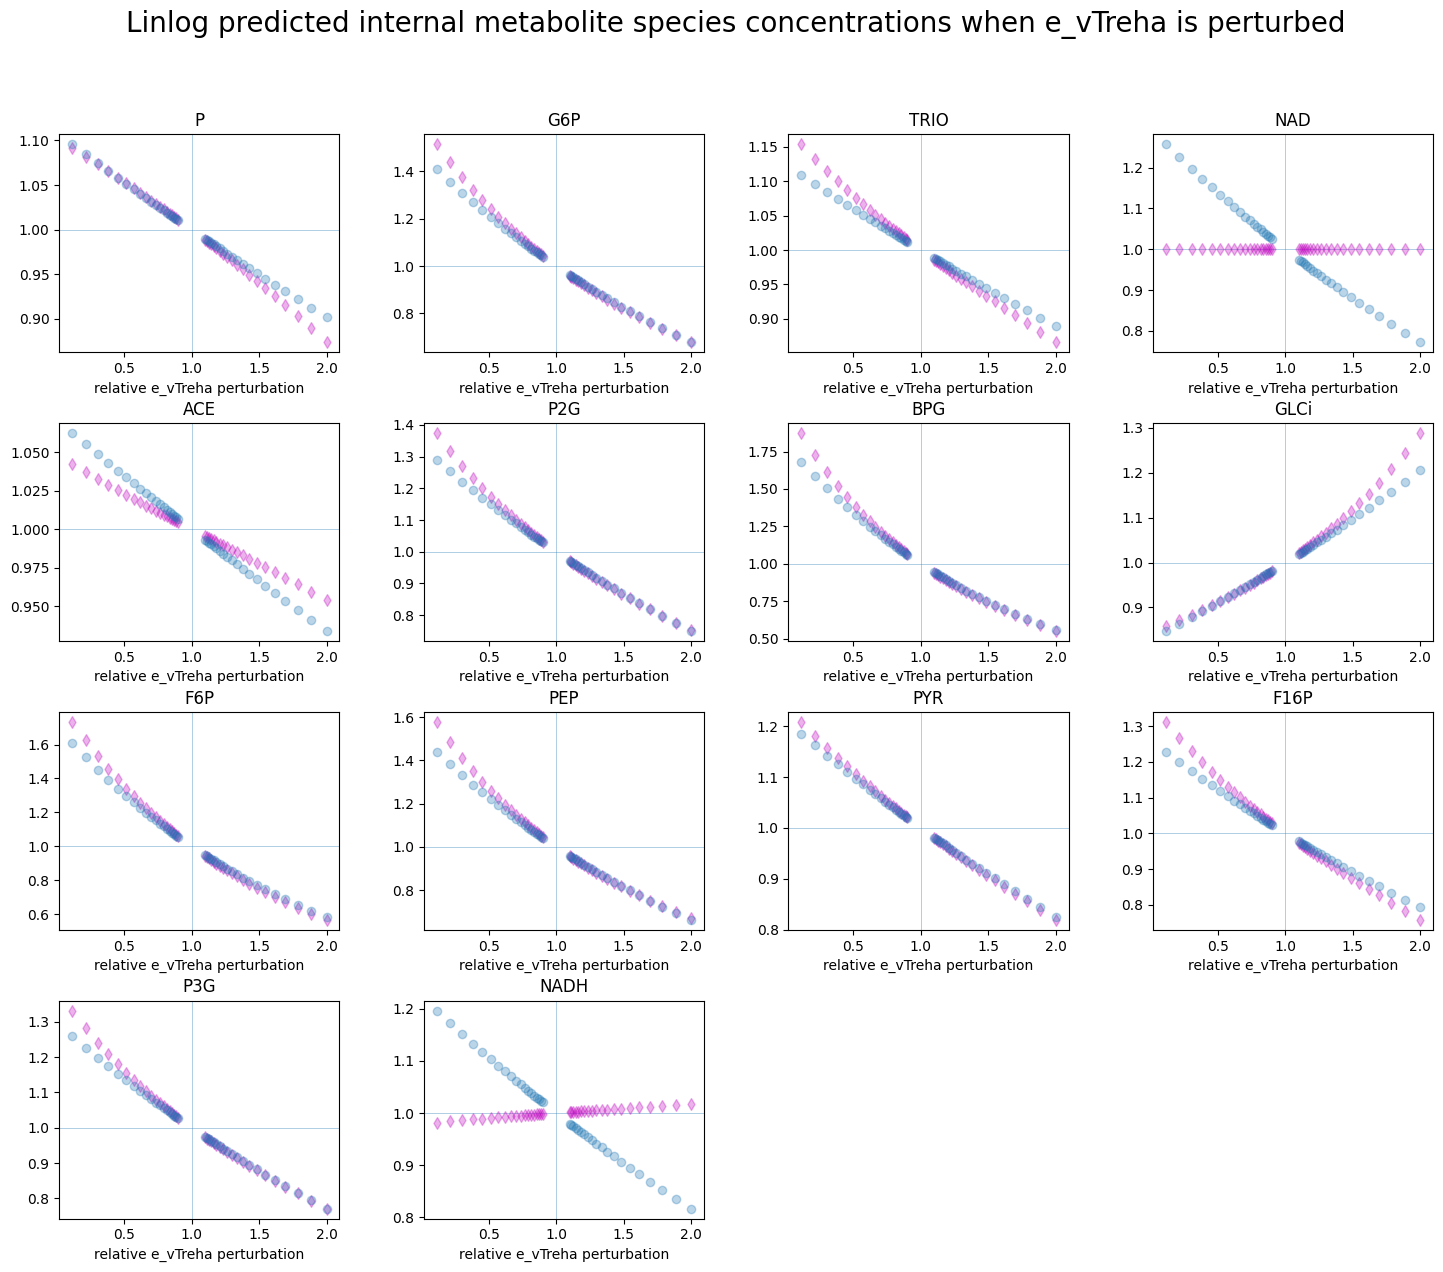

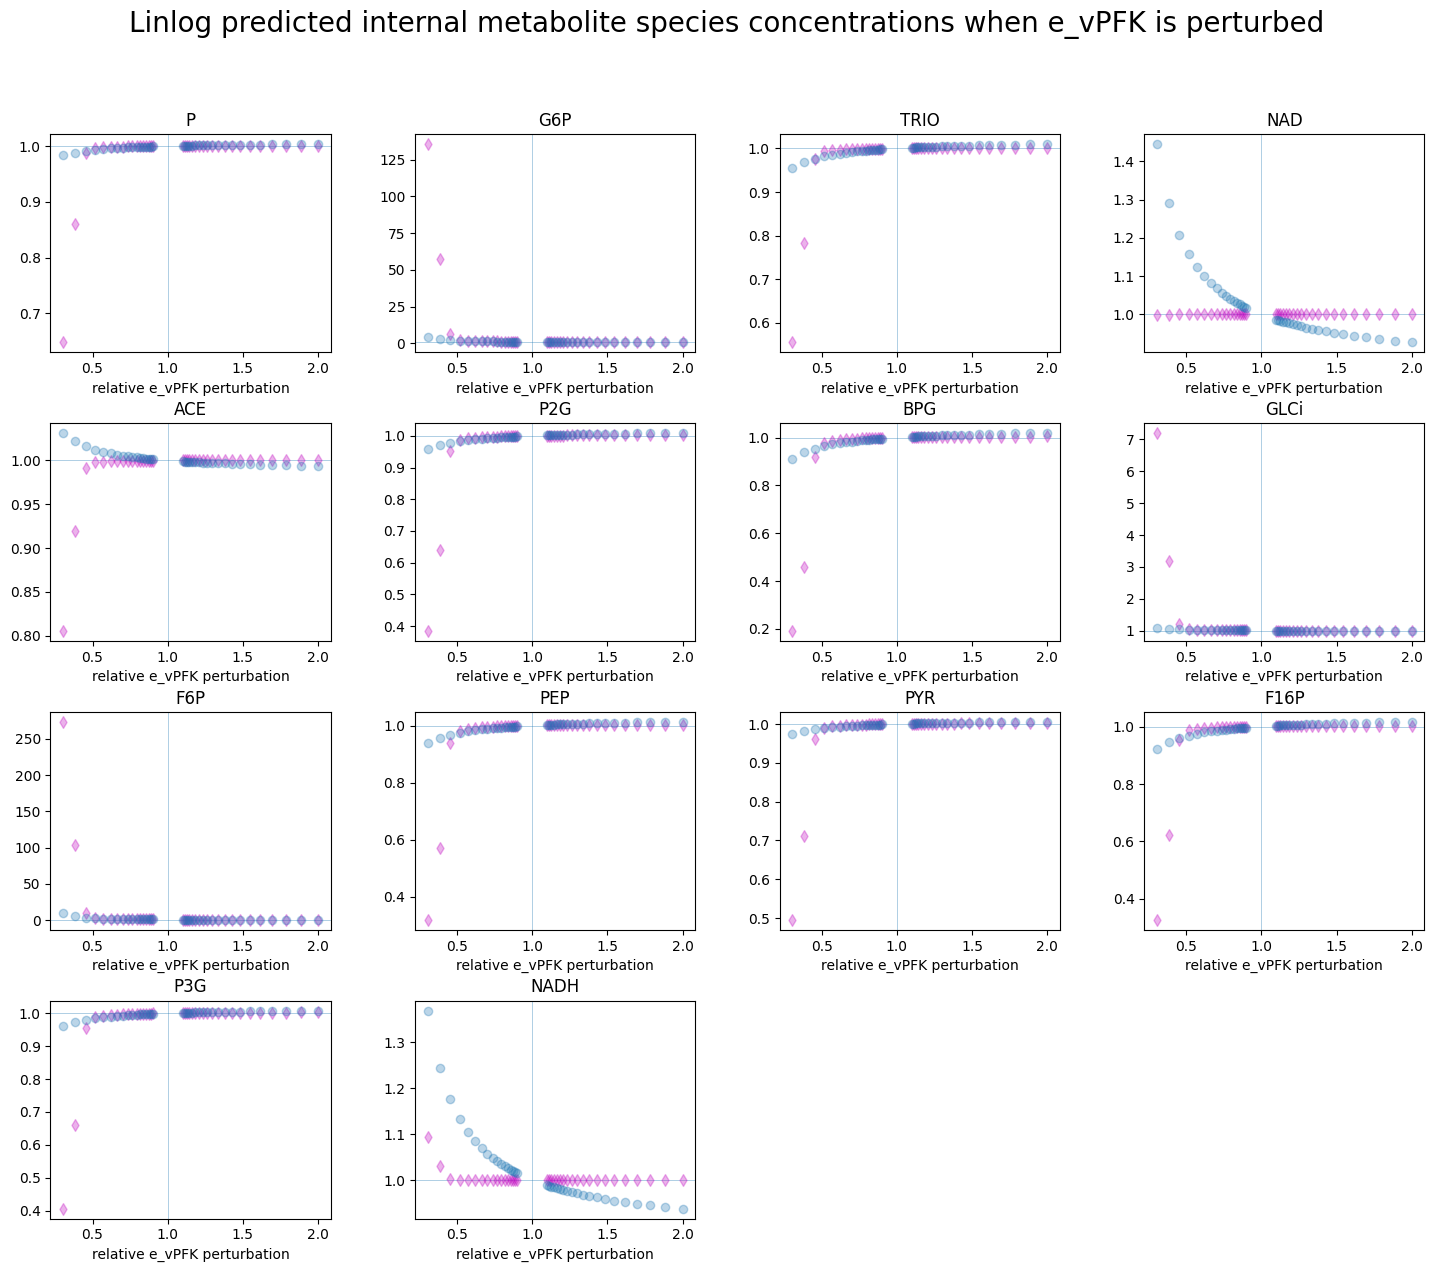

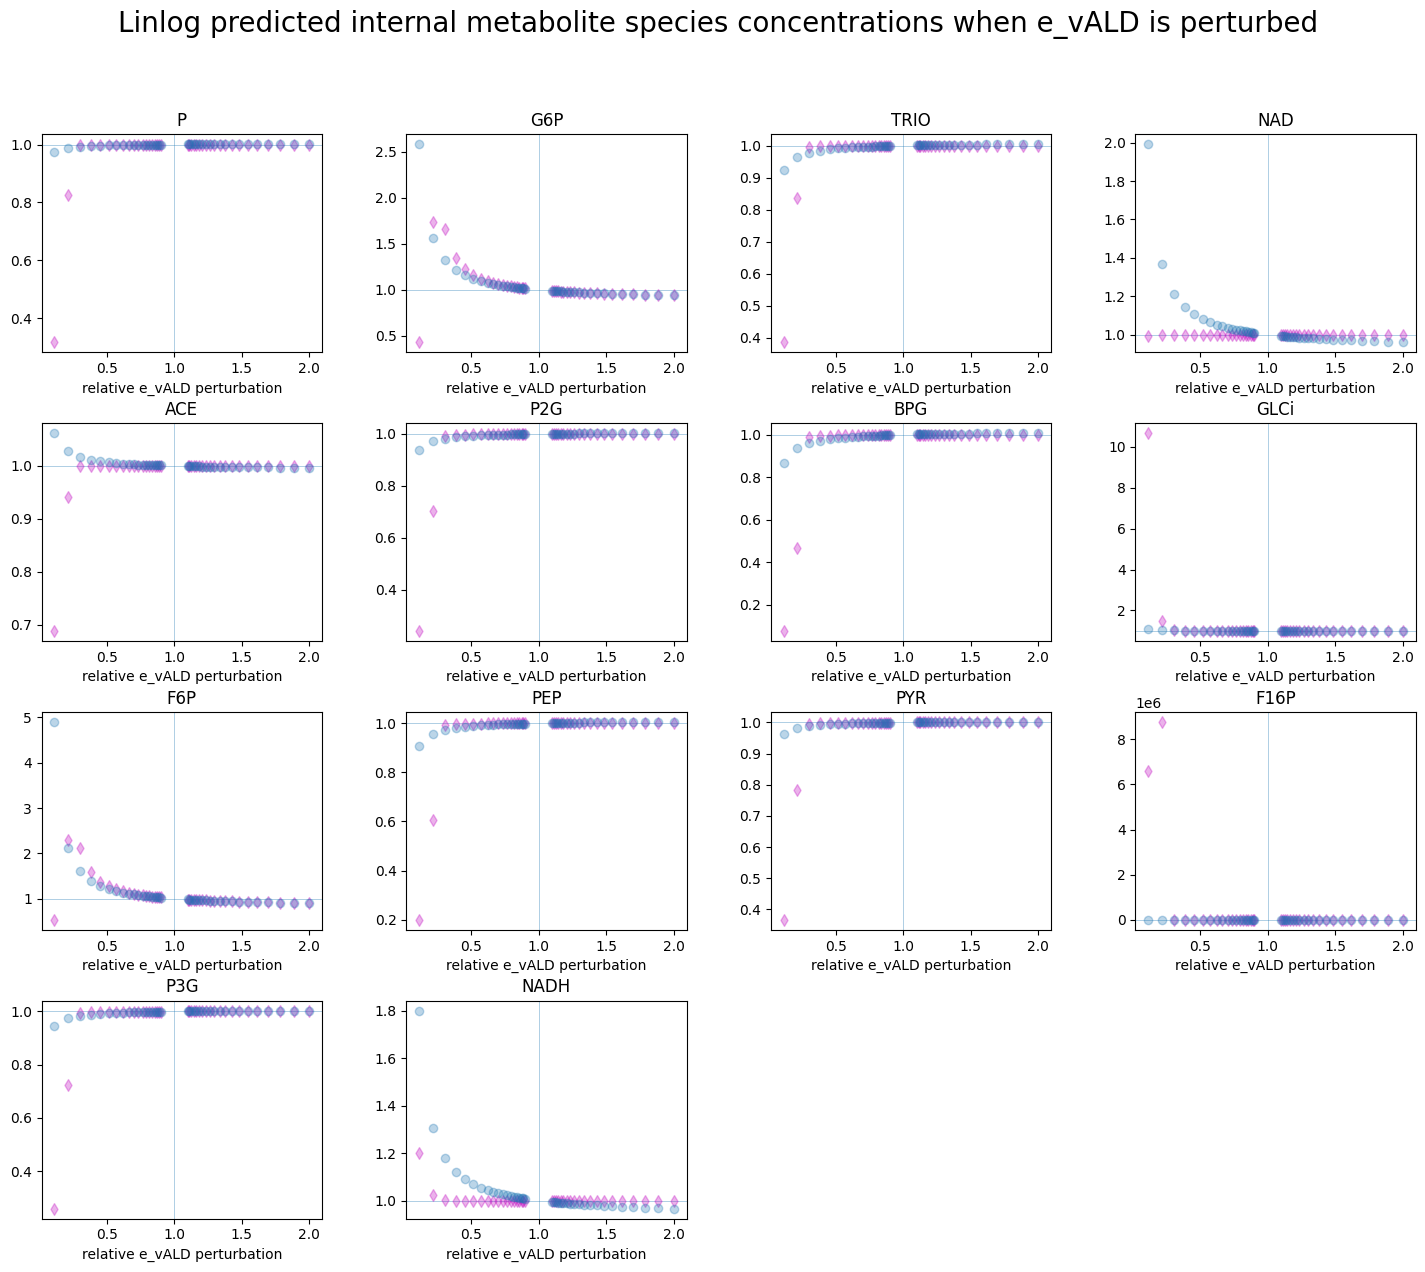

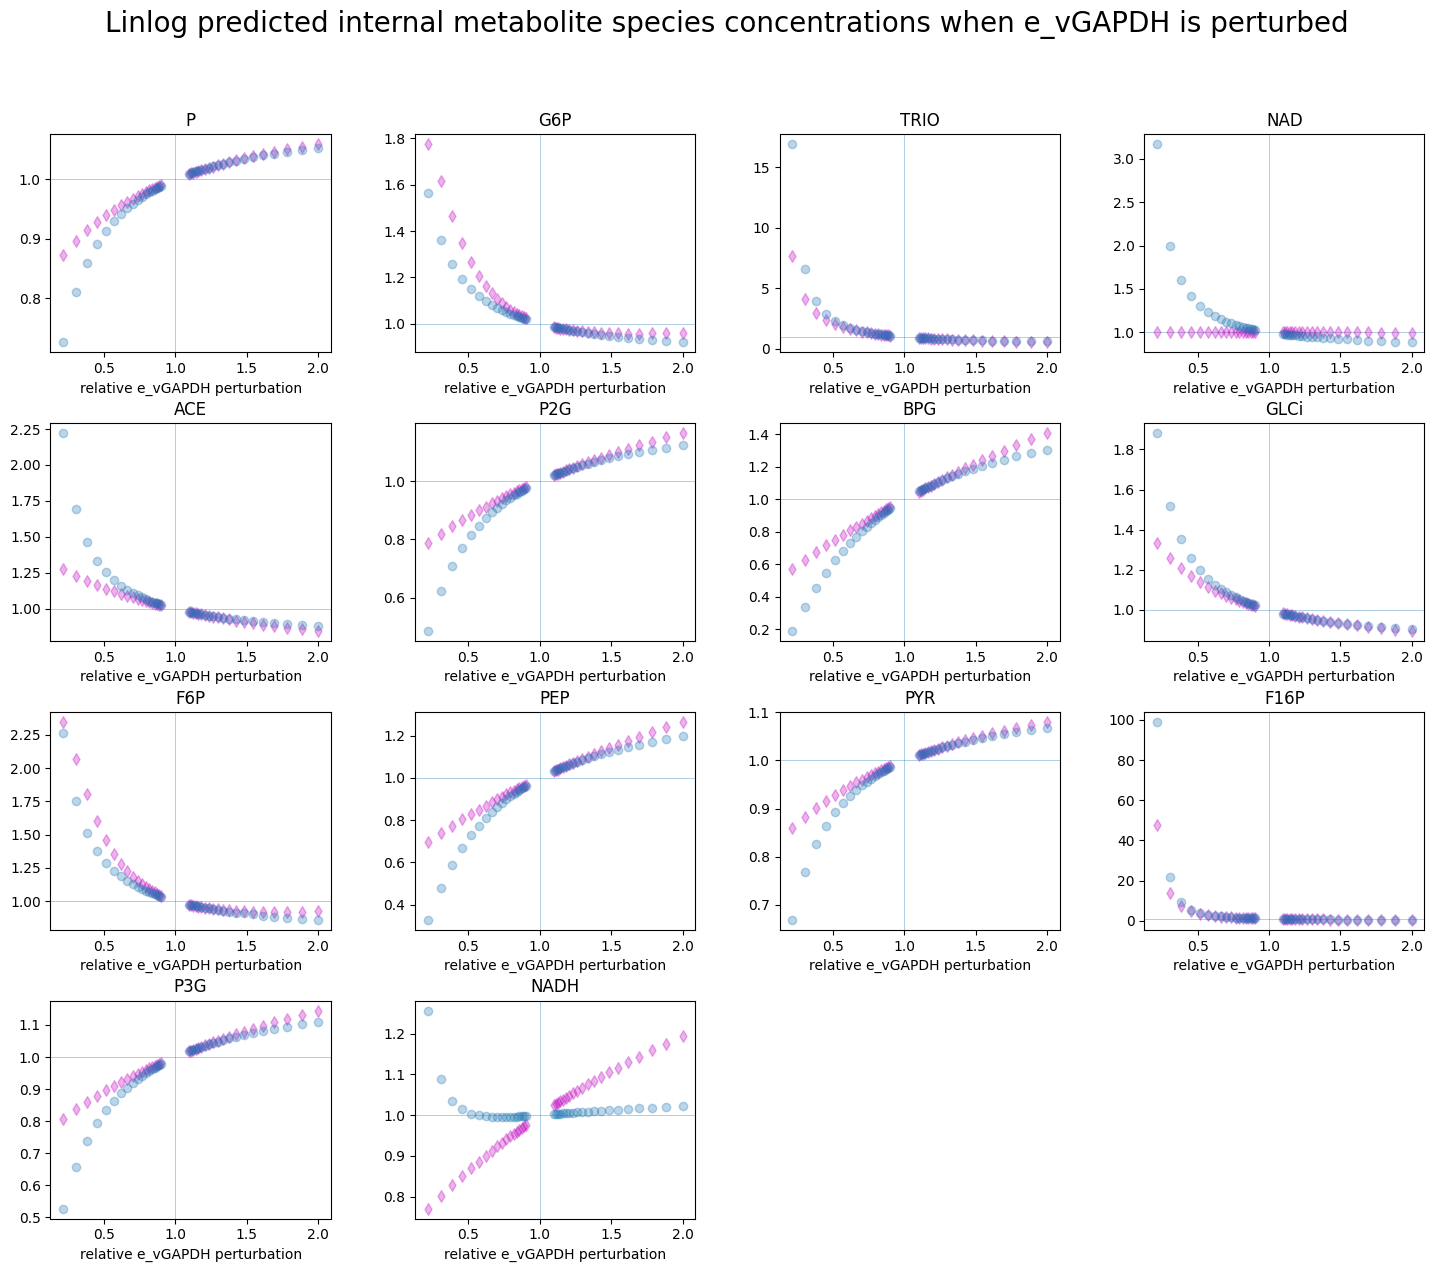

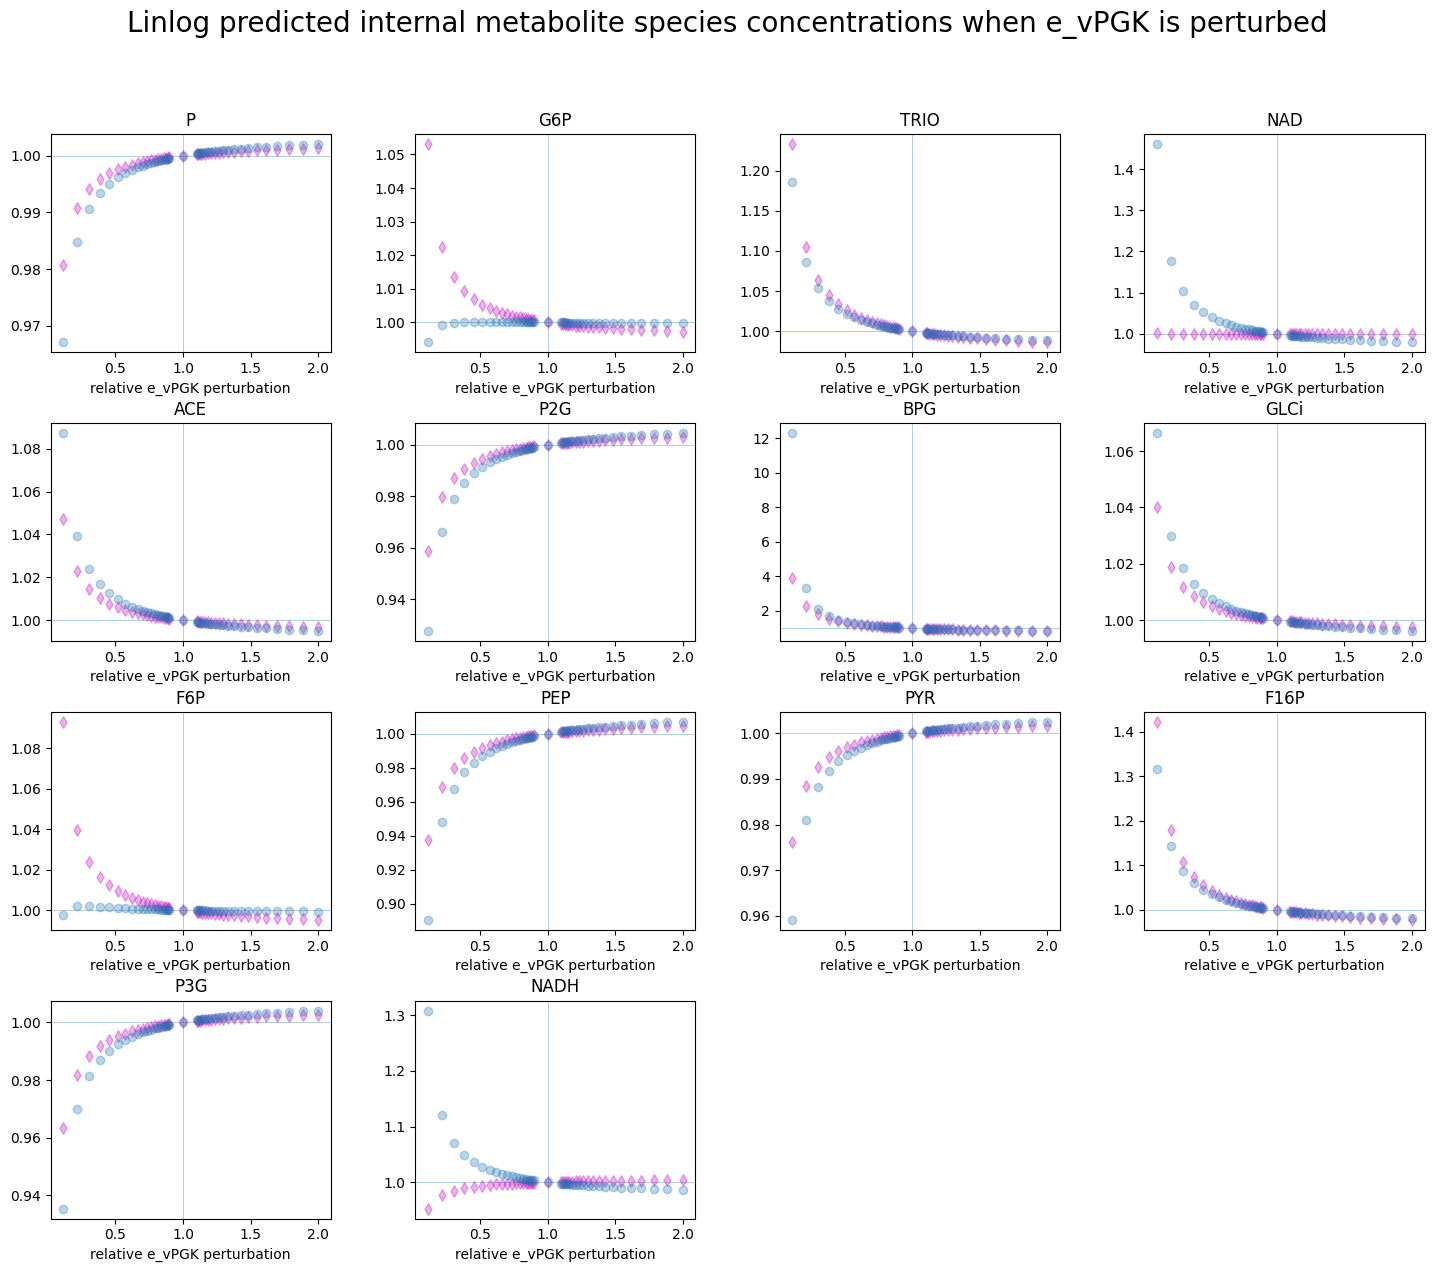

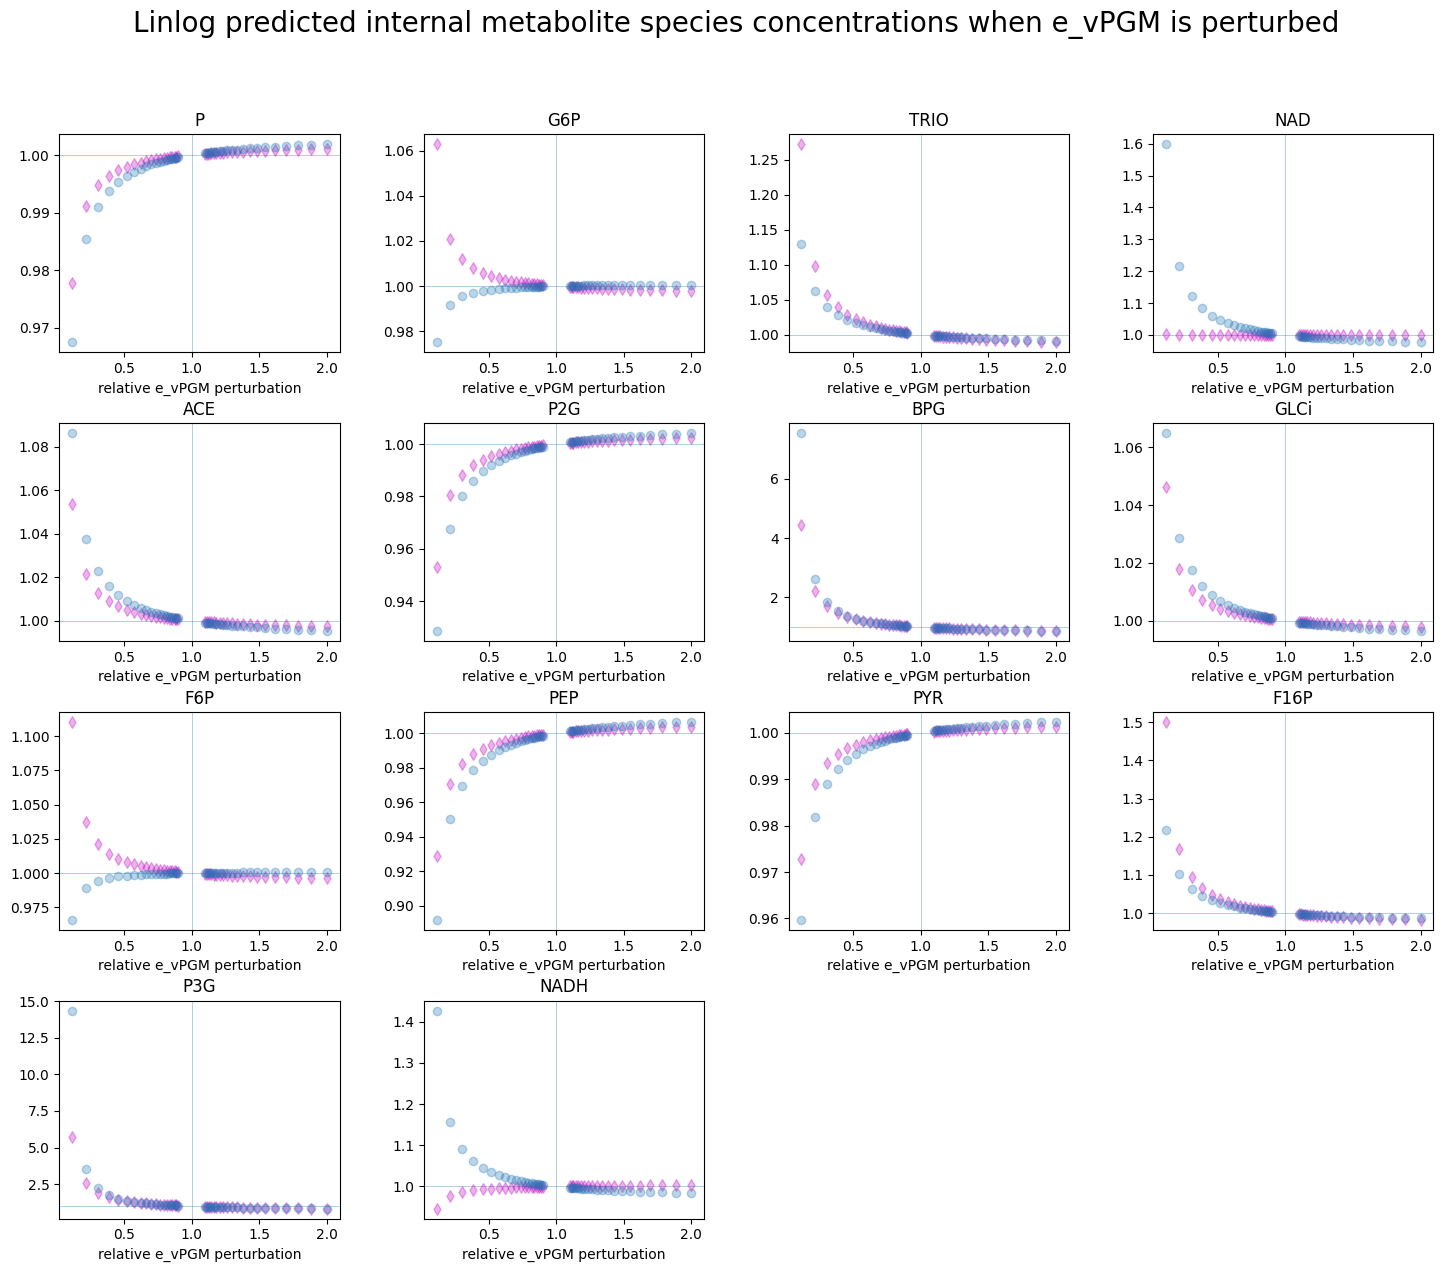

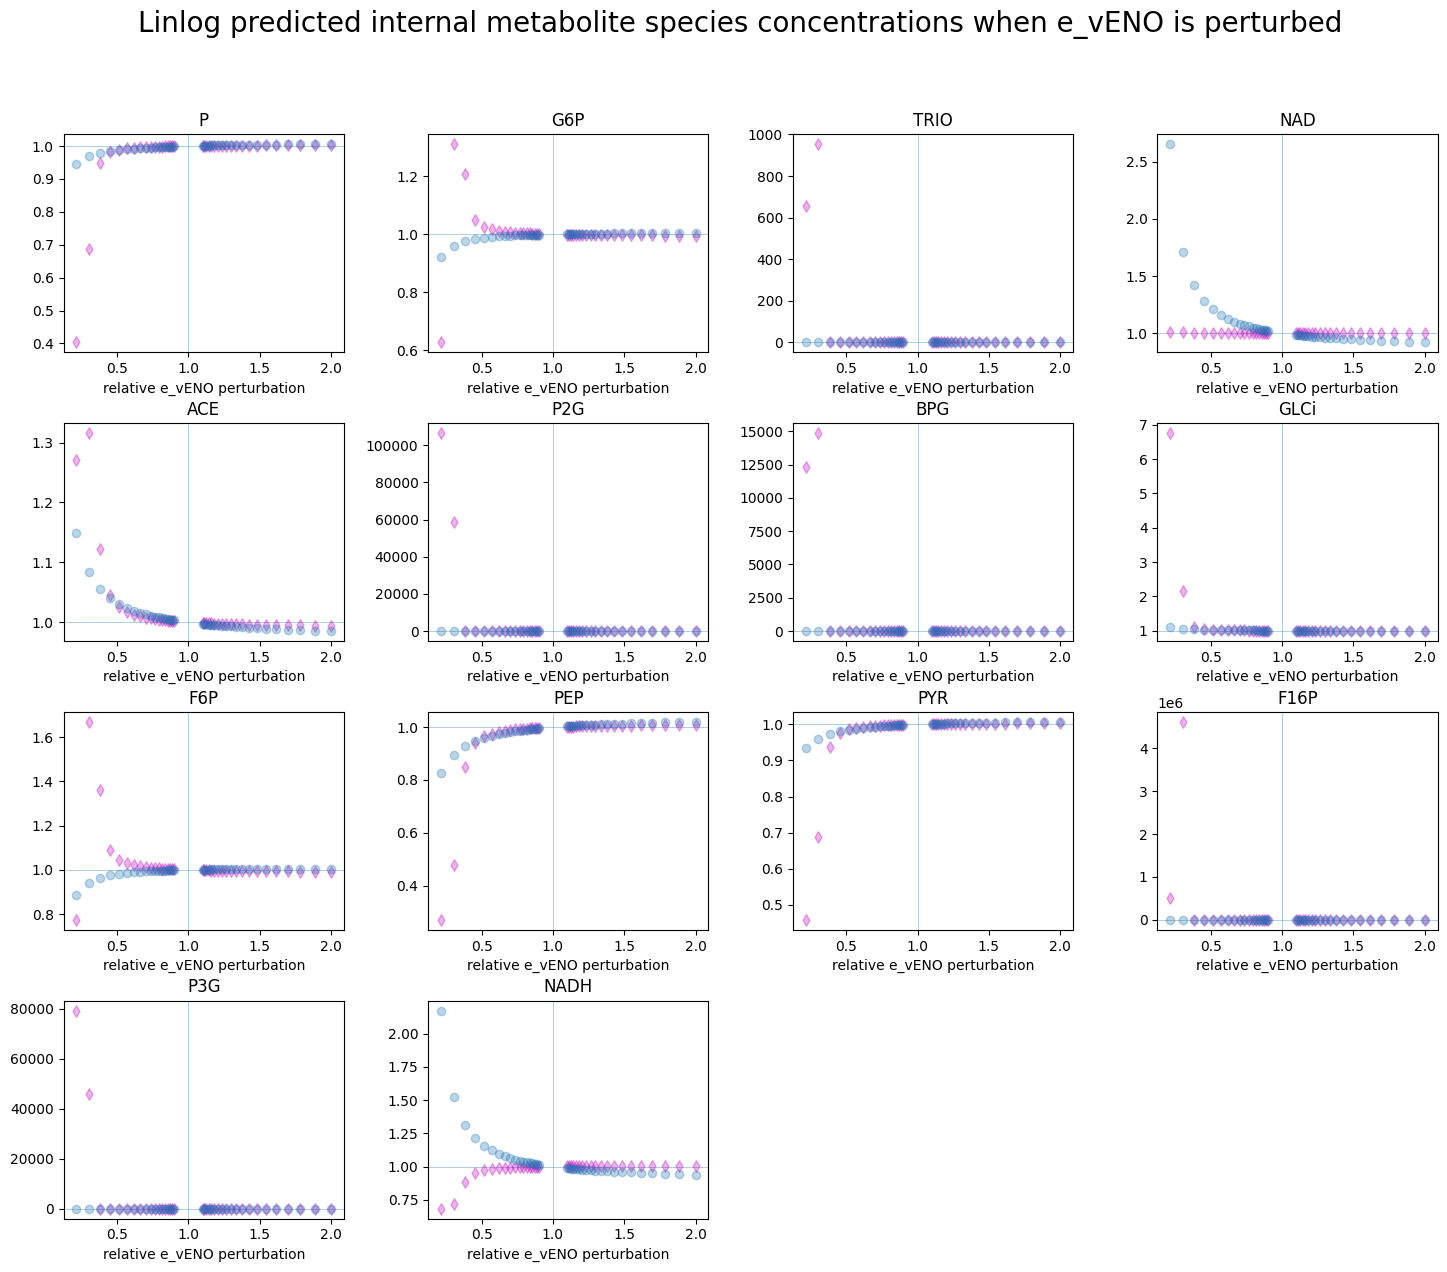

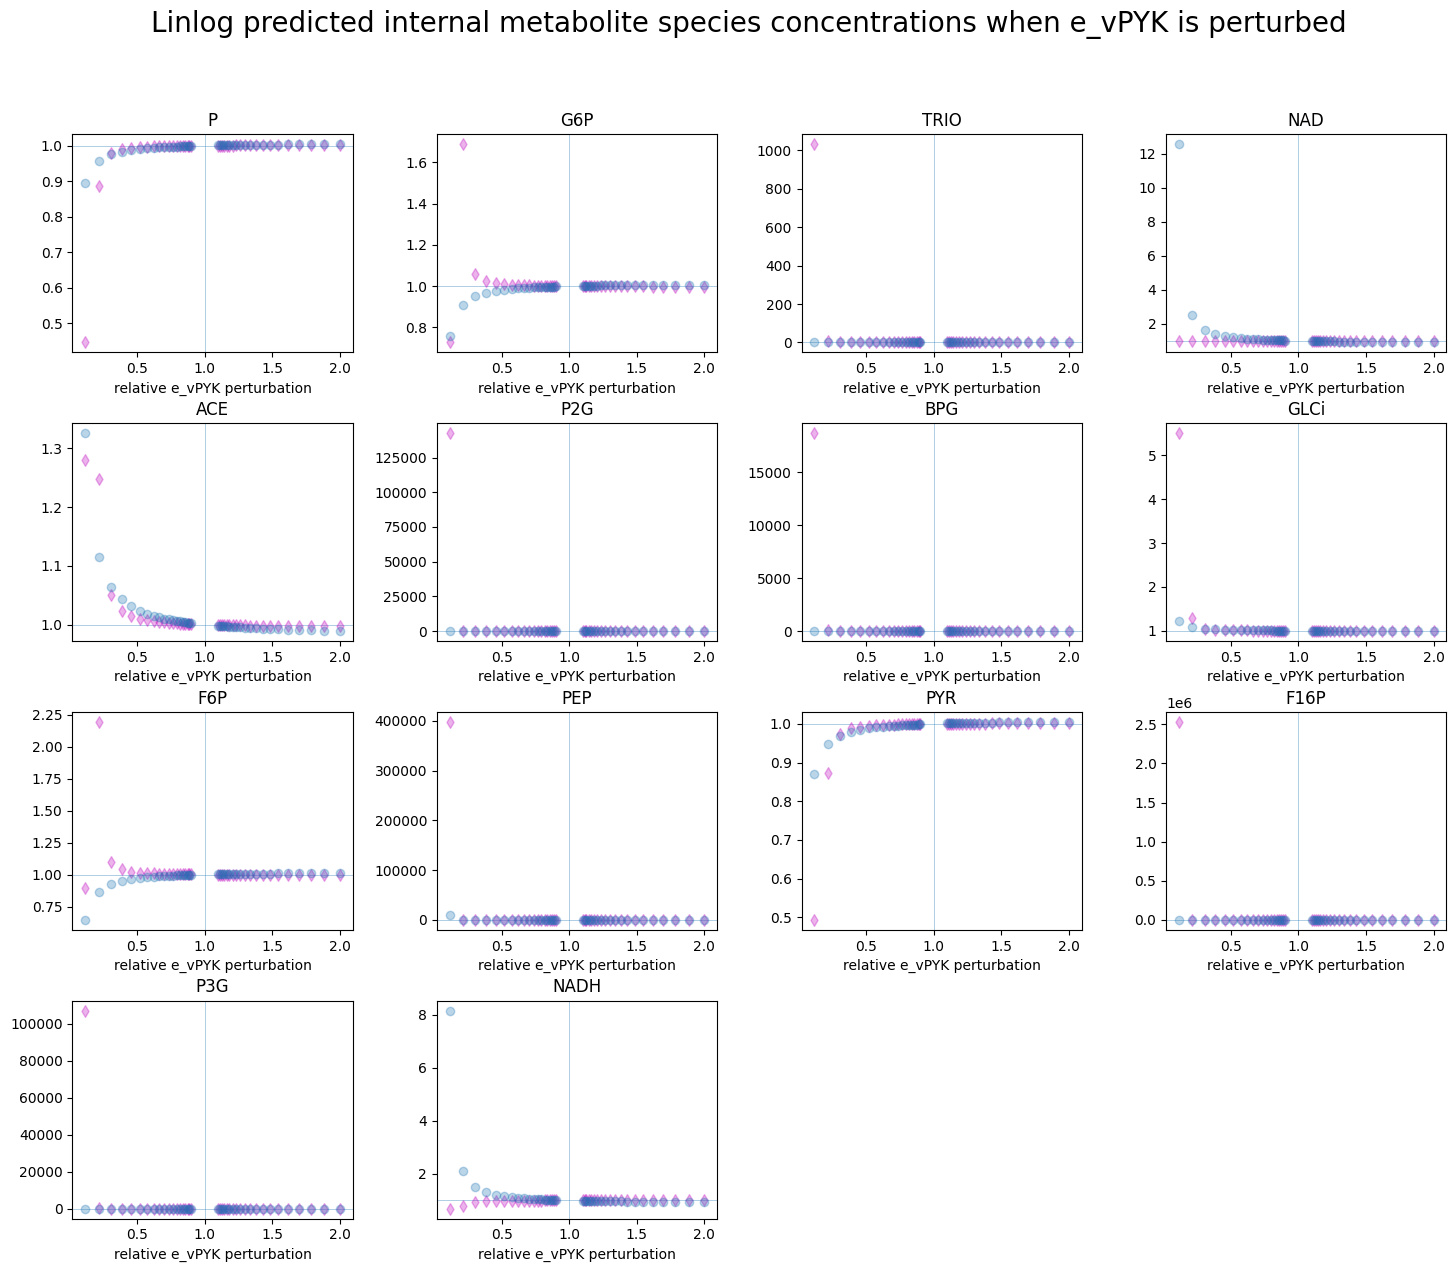

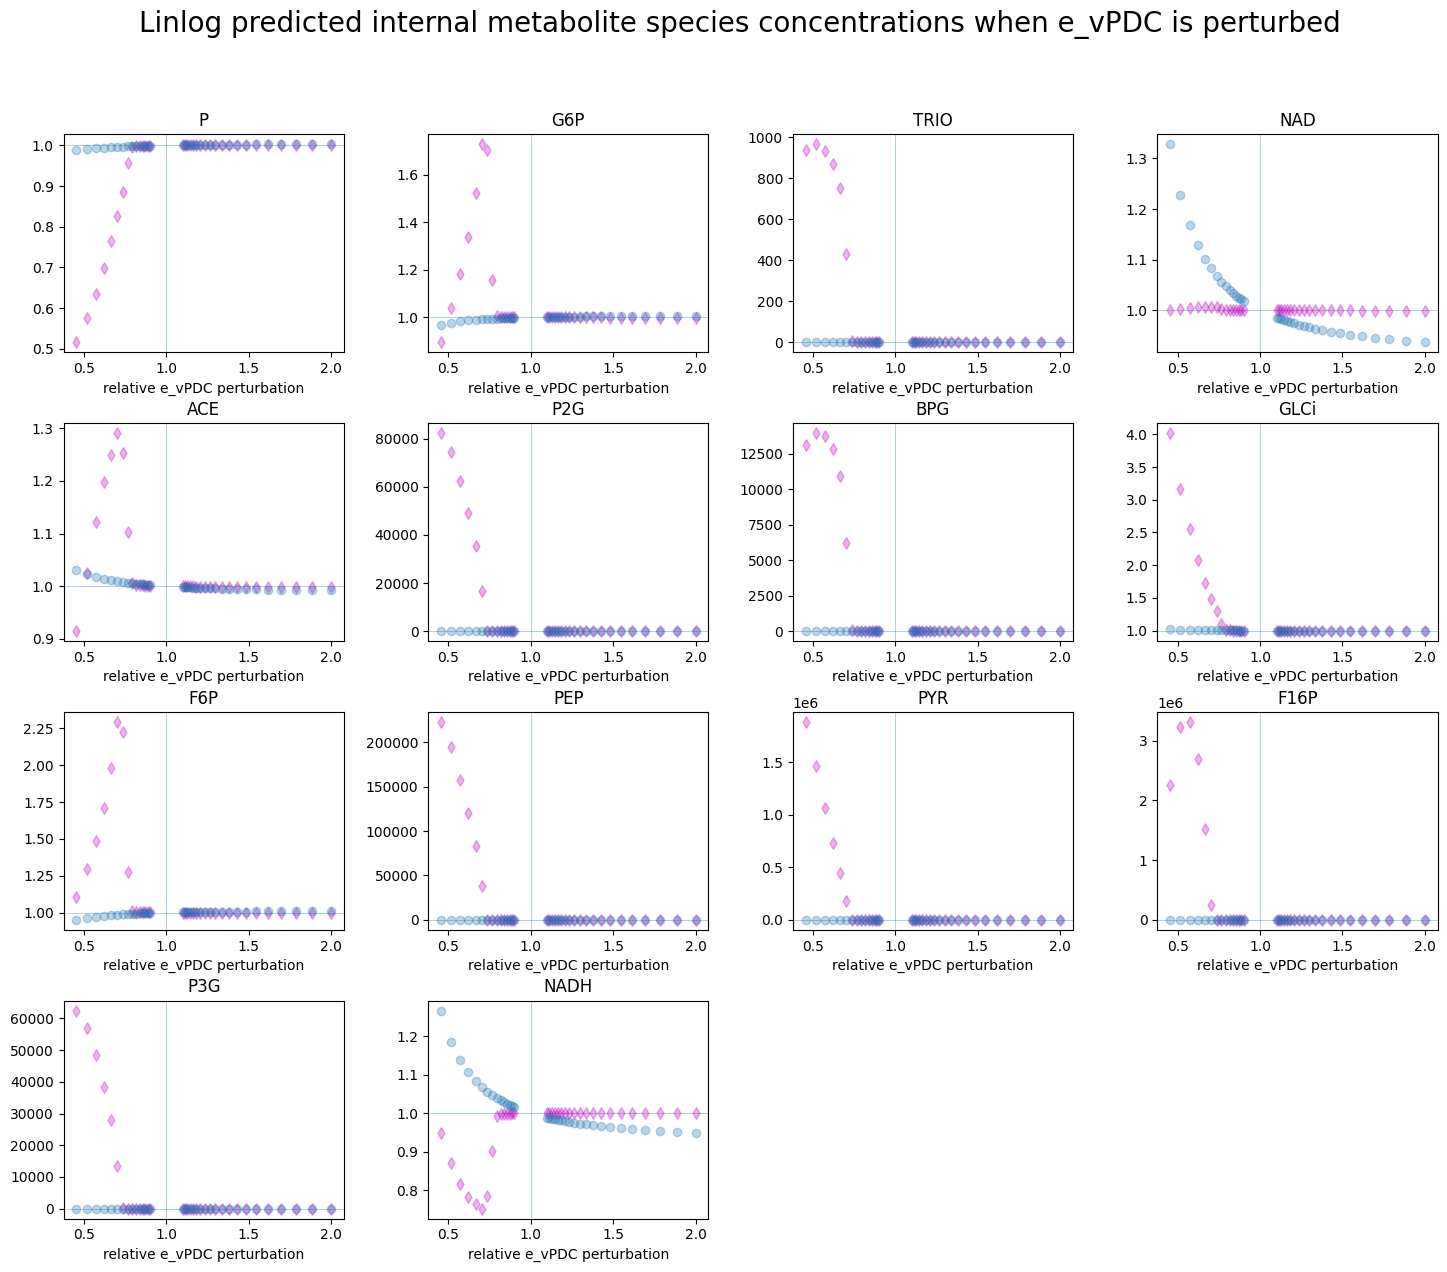

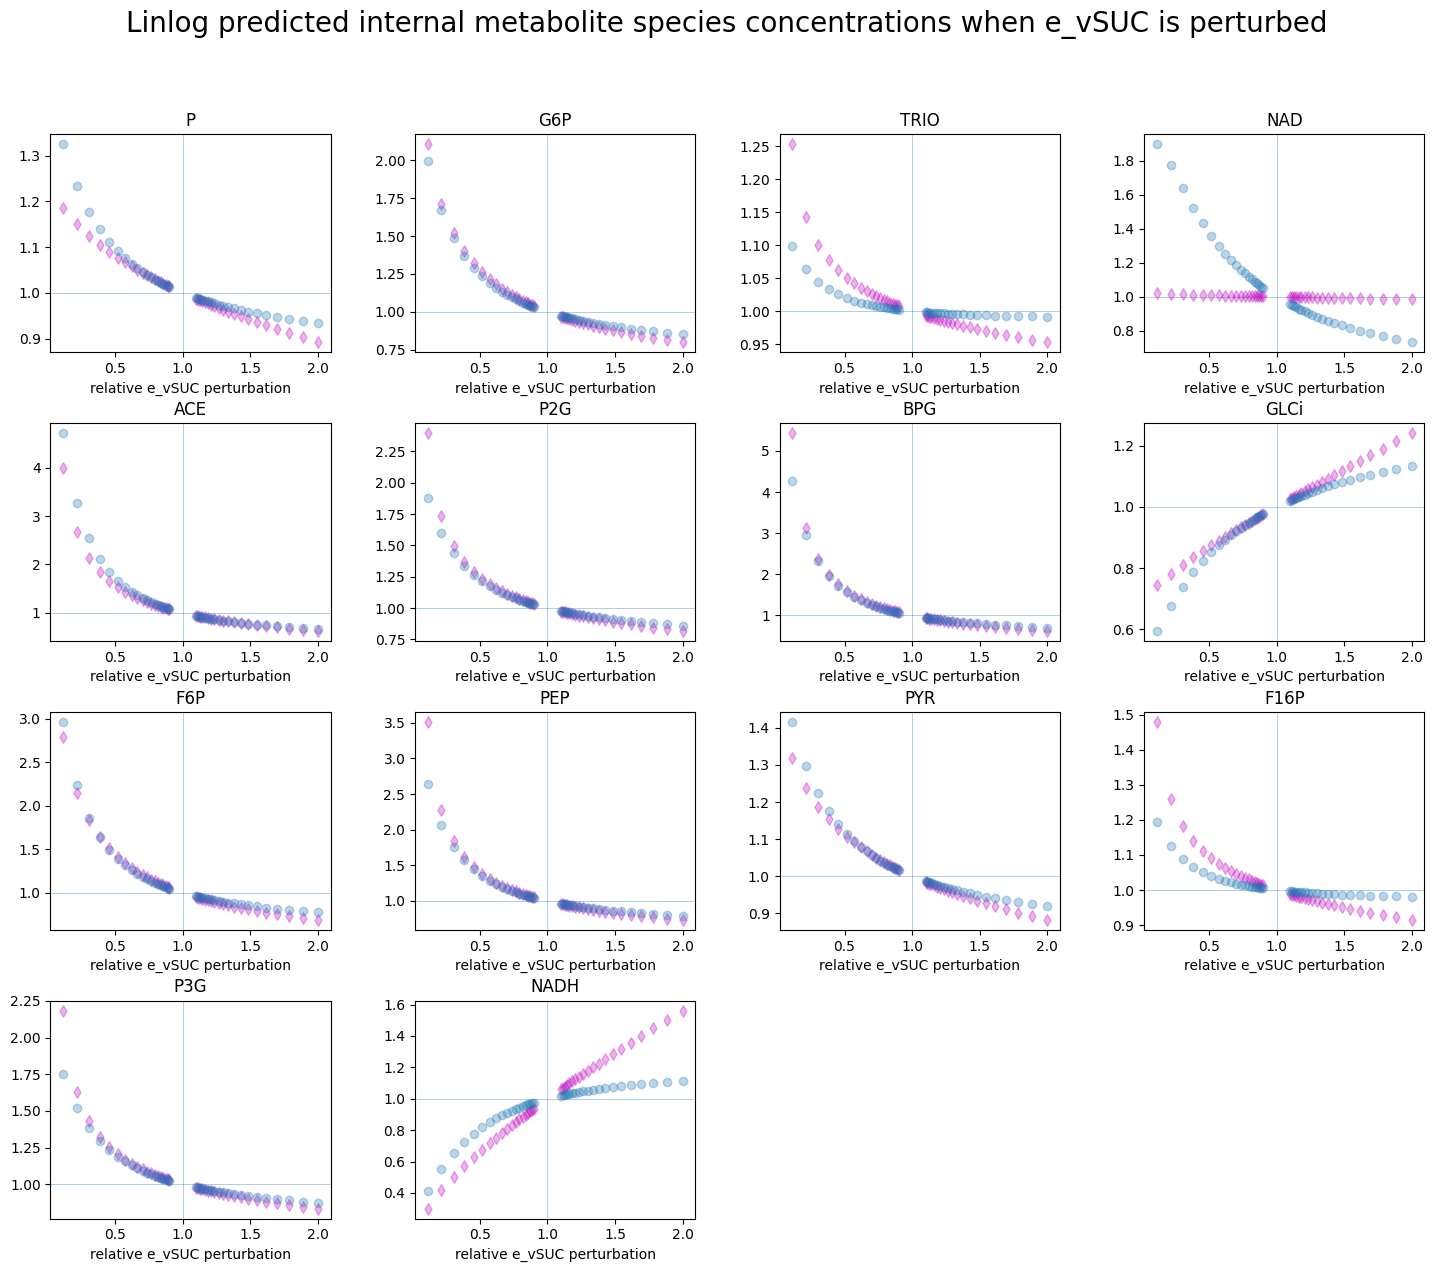

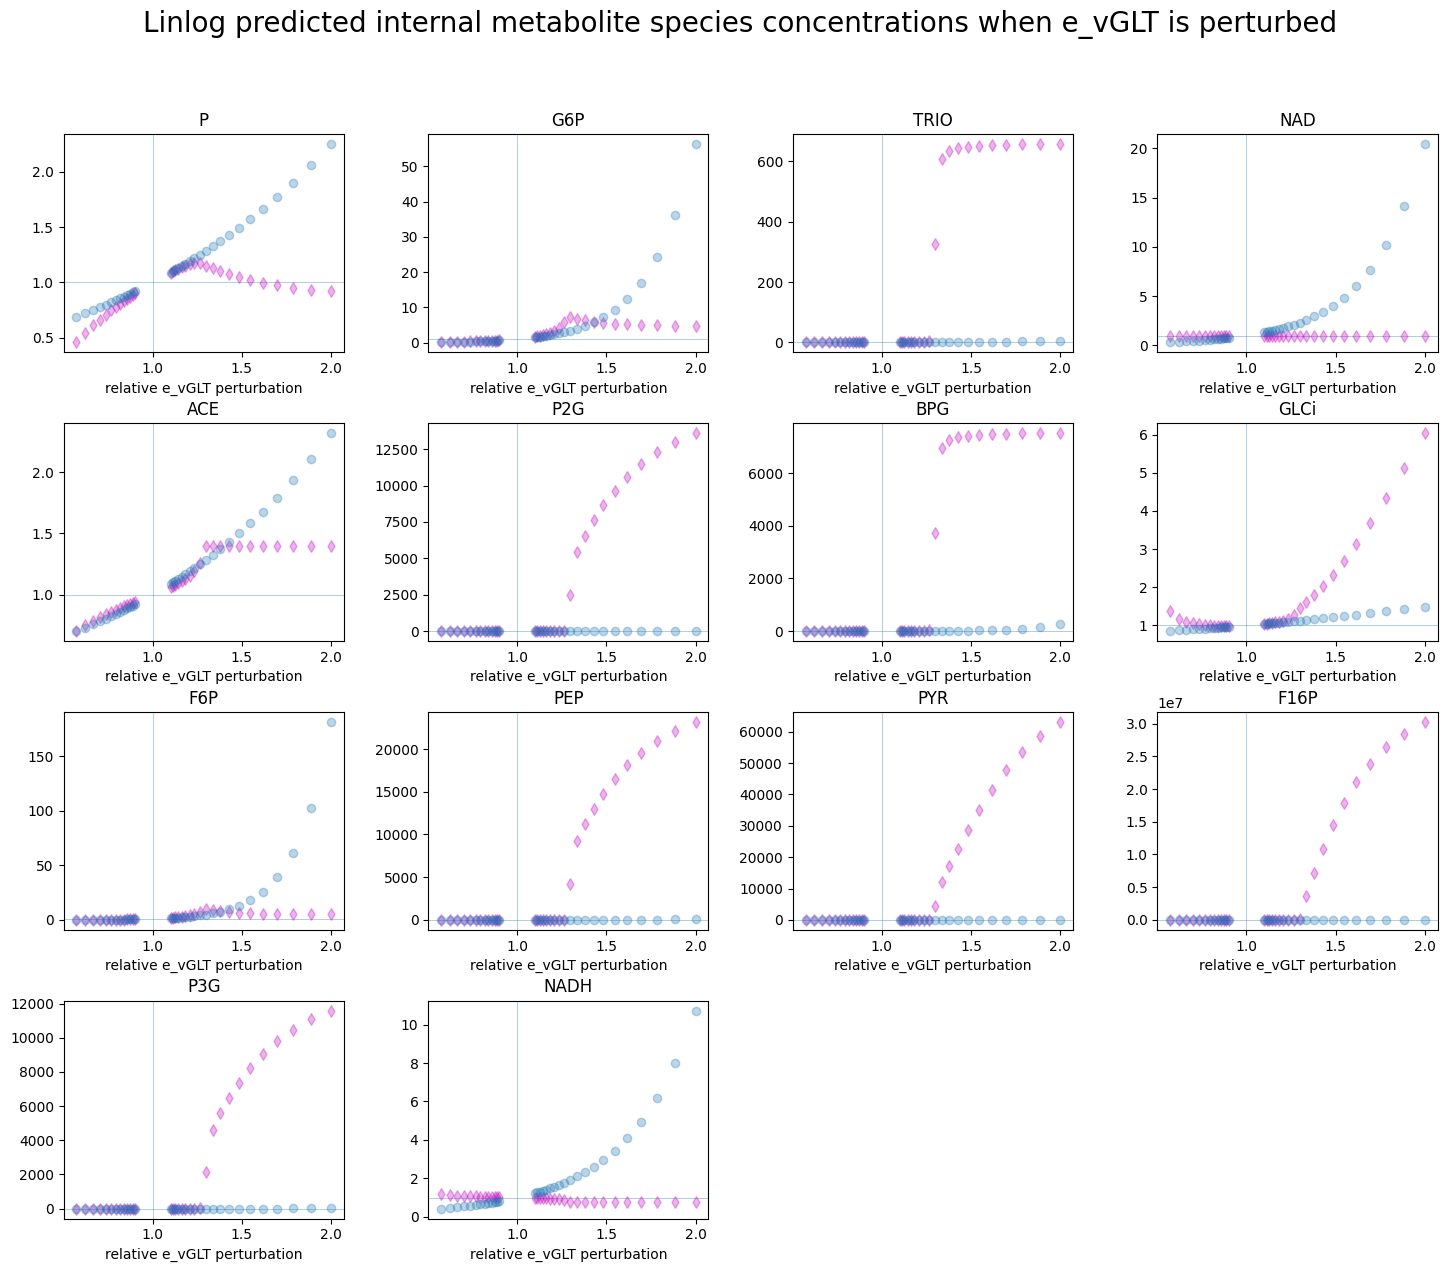

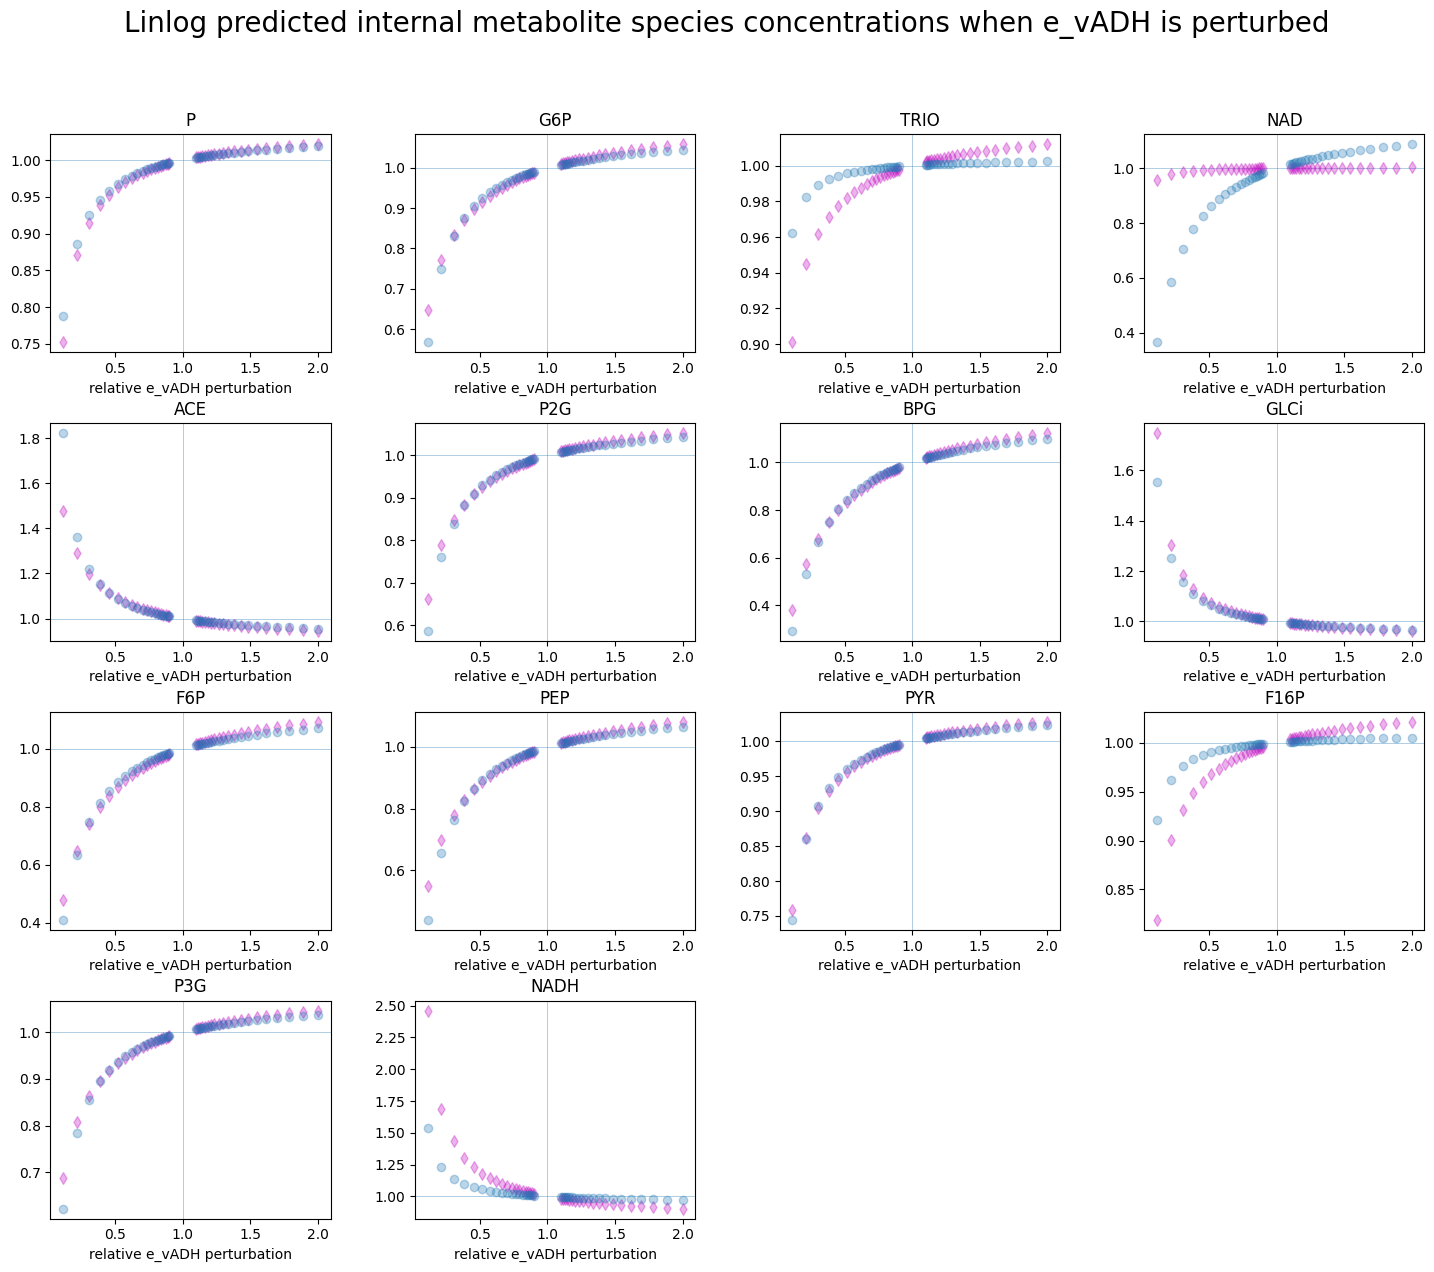

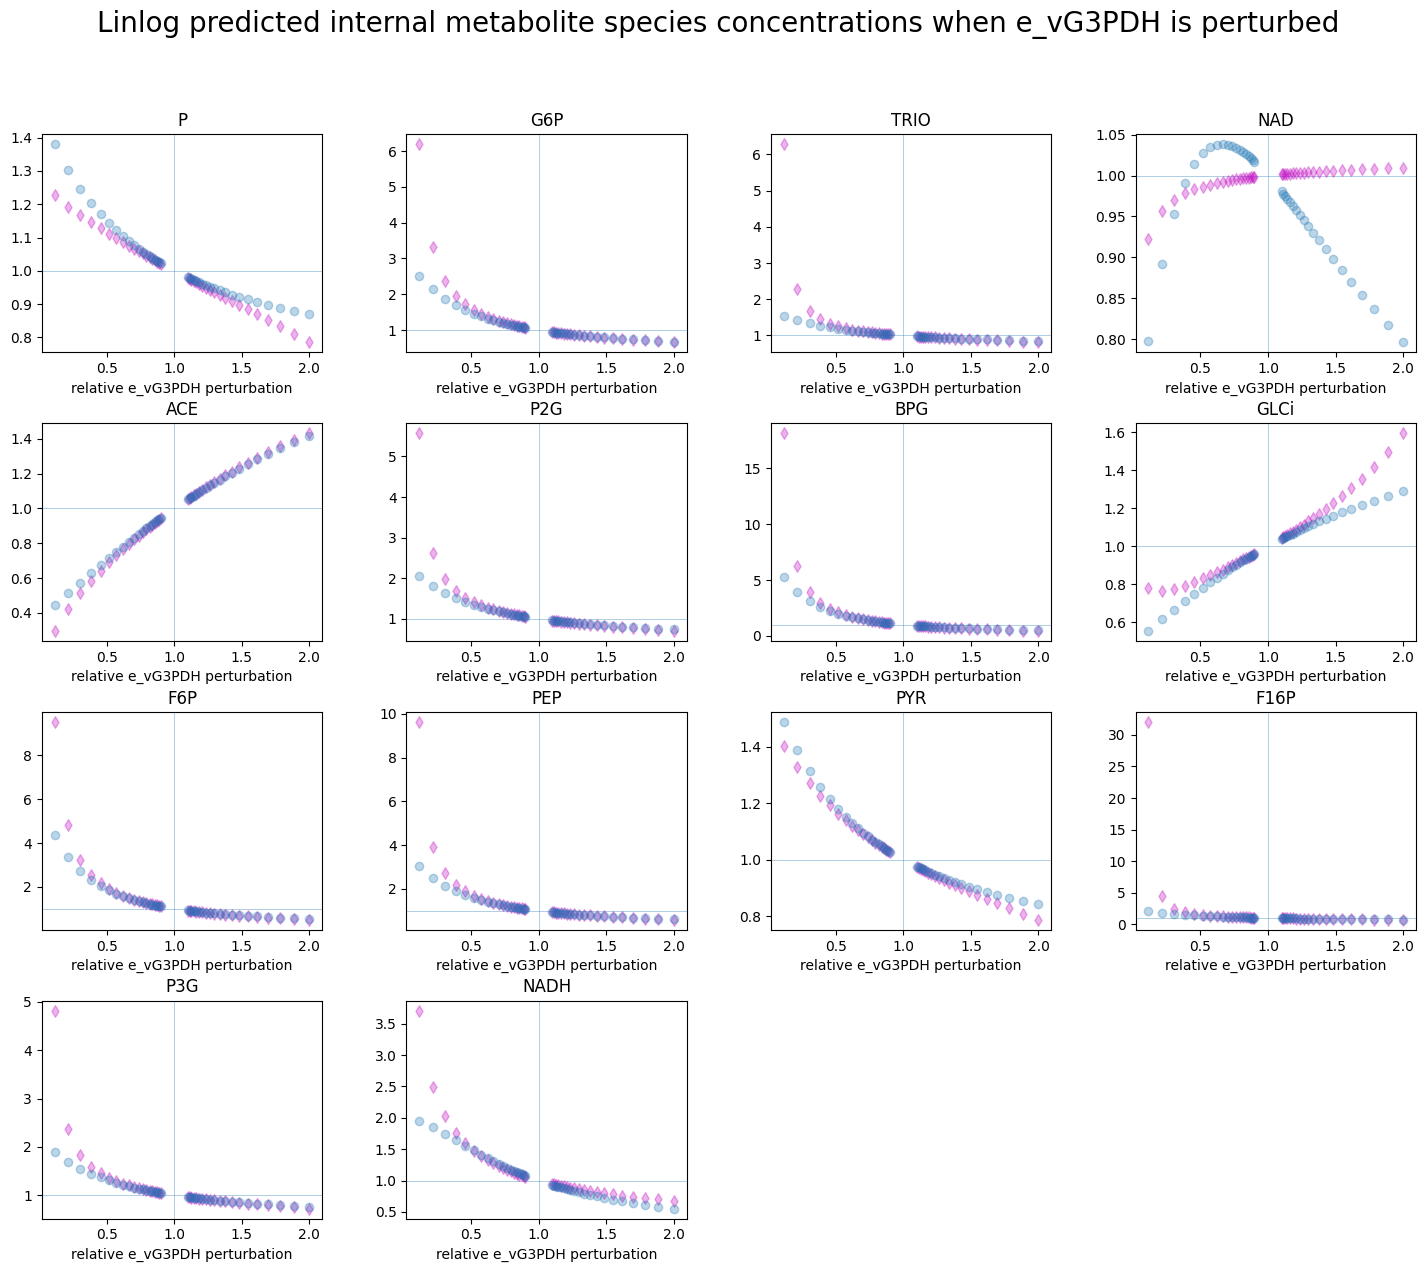

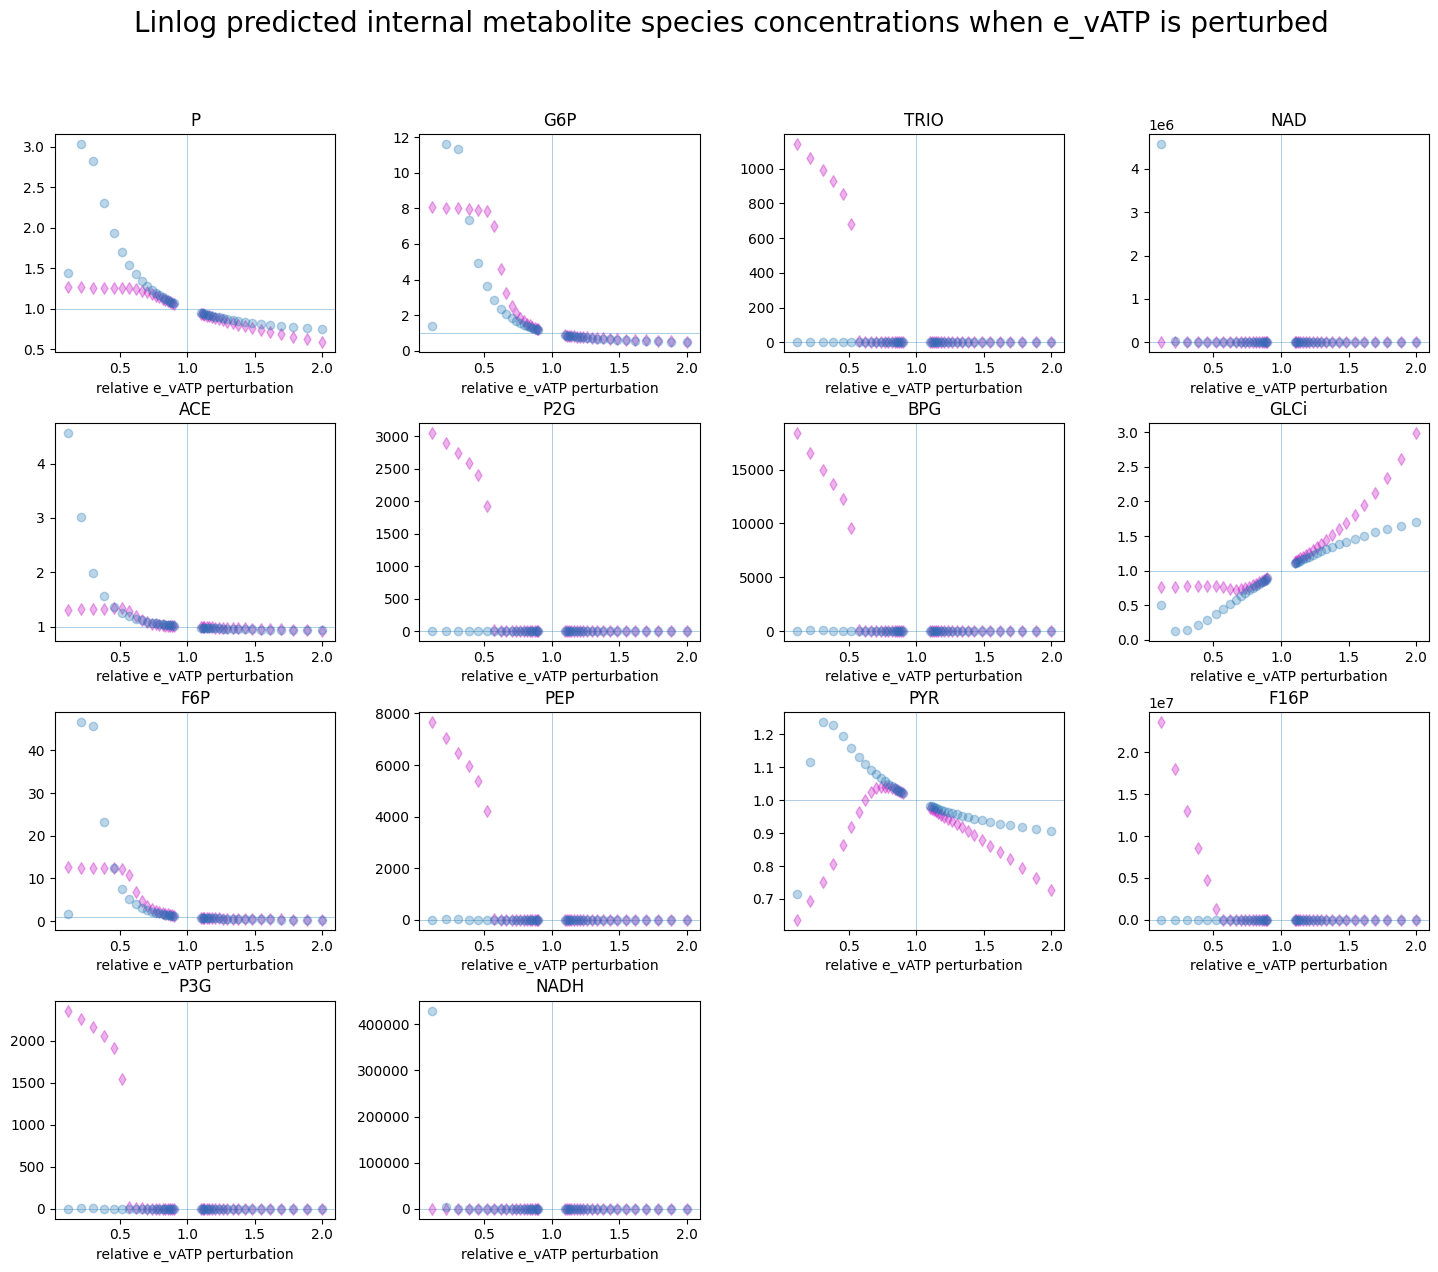

In [15]:
est_Xss = pd.DataFrame(np.exp(np.squeeze(np.array(Xss)).T), index=r.getFloatingSpeciesIds(), columns=enzPtLvls)
for rxn in r.getReactionIds(): 
    est_rxn_Xss = est_Xss[[i for i in est_Xss.columns if rxn in i]]
    est_rxn_Xss.columns = [float(i.split('|')[1]) for i in est_rxn_Xss.columns]
    est_rxn_Xss = est_rxn_Xss.reindex(sorted(est_rxn_Xss.columns), axis=1)
   
    rxn_inmet_perts = rel_real_inmet_values[[i for i in rel_real_inmet_values.columns if rxn in i]] 
    rxn_inmet_perts.columns=[i[7:] for i in rxn_inmet_perts.columns]
    rxn_inmet_perts = rxn_inmet_perts.reindex(sorted(rxn_inmet_perts.columns), axis=1)
    
    fig, axs = plt.subplots(4,4, figsize=(15, 13)) 
    idx_starter = -1

    fig.suptitle(f'Linlog predicted internal metabolite species concentrations when e_{rxn} is perturbed\n', fontsize = 20)
    fig.tight_layout(pad=3.0)

    for i,met in enumerate(r.getFloatingSpeciesIds()):
        if i%4==0:
            idx_starter += 1

        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, rxn_inmet_perts.loc[met].values, alpha=0.3, c='m', marker='d')
        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, est_rxn_Xss.loc[met], alpha=0.3)
        axs[idx_starter, i%4].set_xlabel(f'relative e_{rxn} perturbation')
        axs[idx_starter, i%4].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].set_title(met)
    
    fig.delaxes(axs[3,2]) 
    fig.delaxes(axs[3,3]) 


### Running Bayesian inference for internal steady state concentrations

In [16]:
from emll.aesara_utils import LeastSquaresSolve
def mymethod(e_hat, v_star):
    n_exp = len(e_hat)
    
    v_star = v_star[np.newaxis,:]
    product = (e_hat*v_star)

    def my_func(a): 
        return np.diag(a)
    c = np.apply_along_axis(my_func, 1, product)
    
    N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)
    
    As = (N_rep@c@Ex) # (642, 14, 14)
    
    arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
    arr = arr.T[:,:, np.newaxis]
    bs = -(N_rep@c) @ arr # (642, 14, 642)

    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)
    
    vn = e_hat * (np.ones((17, 642)) +
                   at.dot(Ex, xn.T) +
                   at.dot(Ey, yn.T)).T

    return xn, vn

In [17]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [18]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=e_hat)
    y_obs = pm.Normal('y_obs', mu=1, sigma=10, observed=yn)


In [19]:
with pymc_model:
    
    # likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    xn_ss, vn_ss = mymethod(e_hat, BIOMD64.v_star)
    chi_obs = pm.Normal('chi_obs', mu=xn_ss, sigma=1, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=vn_ss, sigma=1, observed=vn)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [20]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n= N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2.7471e+15
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


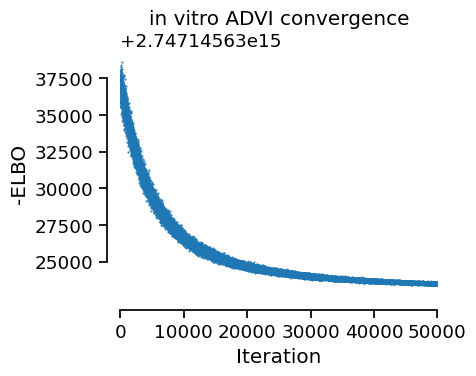

In [21]:
import seaborn as sns
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    # plt.ylim([-1E1, 1E3])
    plt.xlim([0, 50000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)